In [1]:
# suggest the library to import math 
import math
class Value:

    def __init__ (self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev= set(_children)
        self._op = _op
        self.label = label
    
    def __repr__ (self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__ (self, other):
        other = other if isinstance(other, Value) else Value(other) # if other is not a Value object, then make it a Value object
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # out.grad copies the value to self since it it addition
            other.grad += 1.0 * out.grad

        out._backward = _backward # assigning current node to out for next back propagation node 
        return out
    
    def __mul__ (self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__ (self, other): # will swap the order of the operands ; so 2 * a will be a * 2 then a.__mul__(2) will work
        return self * other
    
    def __pow__ (self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad

        out._backward = _backward
        return out

    def __truediv__ (self, other): # self / other
        return self * other ** -1

    def __neg__ (self):
        return -1 * self
    
    def __sub__ (self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) # nothing but tanh(x)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp (self):
        x = self.data
        t = math.exp(x)
        out = Value(t, (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self): # last node of back propagation
        topo = []
        visited = set()
        def topological_sort(x):
            if x in visited:
                return
            visited.add(x) # adds children to the set
            for child in x._prev: # self._prev = set(_children) of all children
                topological_sort(child)
            topo.append(x)

        topological_sort(self) # sorted based on last node 

        self.grad = 1.0
        for node in reversed(topo):
            node._backward() # calling the function _backward() of each node
        

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

print(d)

Value(data=4.0, label=d)


In [4]:
from graphviz import Digraph
#from micrograd.engine import Value
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        # dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record') 
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

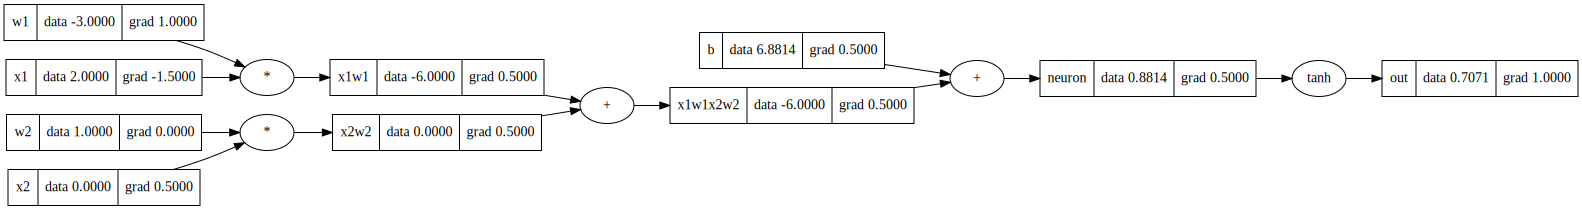

In [13]:
#inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
neuron = x1w1x2w2 + b; neuron.label = 'neuron'
out = neuron.tanh(); out.label = 'out'

out.backward()

draw_dot(out)

In [12]:
a = Value(2.0, label='a')
a + 1 
a * 2 
#will work; but 2 * a will not work so use rmul 
a*2
b = a.exp()
print (b)
a = Value(2.0, label='a')
b = Value(4.0, label='b')
a/b
a - b
b - a

Value(data=7.38905609893065, label=)


Value(data=2.0, label=)

https://www.youtube.com/watch?v=VMj-3S1tku0&t=507s
Stopped at 1.32

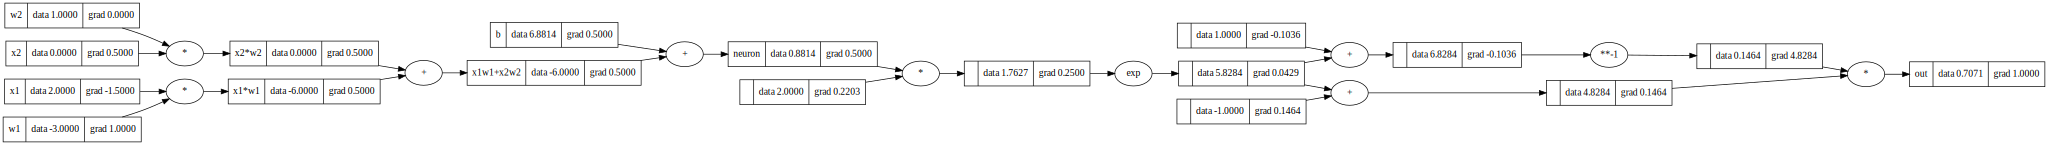

In [15]:
#inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
neuron = x1w1x2w2 + b; neuron.label = 'neuron'
# out = neuron.tanh(); out.label = 'out'
# We are going to change tanh into another identity function because we have created all basic operations like +, -, *, /, exp, etc. 
# tanh = (exp(2x) - 1) / (exp(2x) + 1)
e = (2 * neuron).exp()
out = (e - 1) / (e + 1); out.label = 'out'

out.backward()

draw_dot(out)

In [3]:
pip install torch;

     ------------------------------------- 162.6/162.6 MB 16.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
out = torch.tanh(n)

print (out.data.item())
out.backward()

print ('x1', x1.grad.data.item())
print ('x2', x2.grad.data.item())
print ('w1', w1.grad.data.item())
print ('w2', w2.grad.data.item())

x2.grad


0.7071066904050358
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


tensor([0.5000], dtype=torch.float64)

In [11]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [15]:
# import the module that contains random.uniform function 
import random
import torch

class Neuron:

    def __init__(self, nin): # nin = number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        t =  (list(zip(self.w, x)))
        act = sum([wi*xi for wi, xi in t] , self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b] # return a list of all the parameters of the neuron (weights and bias - list + list = list)
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for nueron in self.neurons for p in nueron.parameters()] # return a list of all the parameters of the layer (all the parameters of all the neurons in the layer)
        # another way to write this is:
        # params = []
        # for nueron in self.neurons:
        #     ps = nueron.parameters()
        #     params.extend(ps)
        # return params

    
class MLP:

    def __init__(self, nin, nout): # nout = list of number of neurons in each layer, nin = number of inputs 
        sz = [nin] + nout
        print (sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [16]:
# x = [2.0, 3.0]
# # n = Neuron(2)
# n = Layer(2, 3) # 3 neurons in the layer and each neuron has 2 dimensions / inputs
# n(x) # This notation will call __call__

x = [2.0, 3.0, -1.0] # 3 inputs in input 
n = MLP(3, [4, 4, 1] ) # 3 inputs, 4 neurons in the first layer, 4 neurons in the second layer, 1 neuron in the third layer
n(x)

[3, 4, 4, 1]


Value(data=0.6833993137246862, label=)

In [18]:
n.parameters()
len(n.parameters())

41

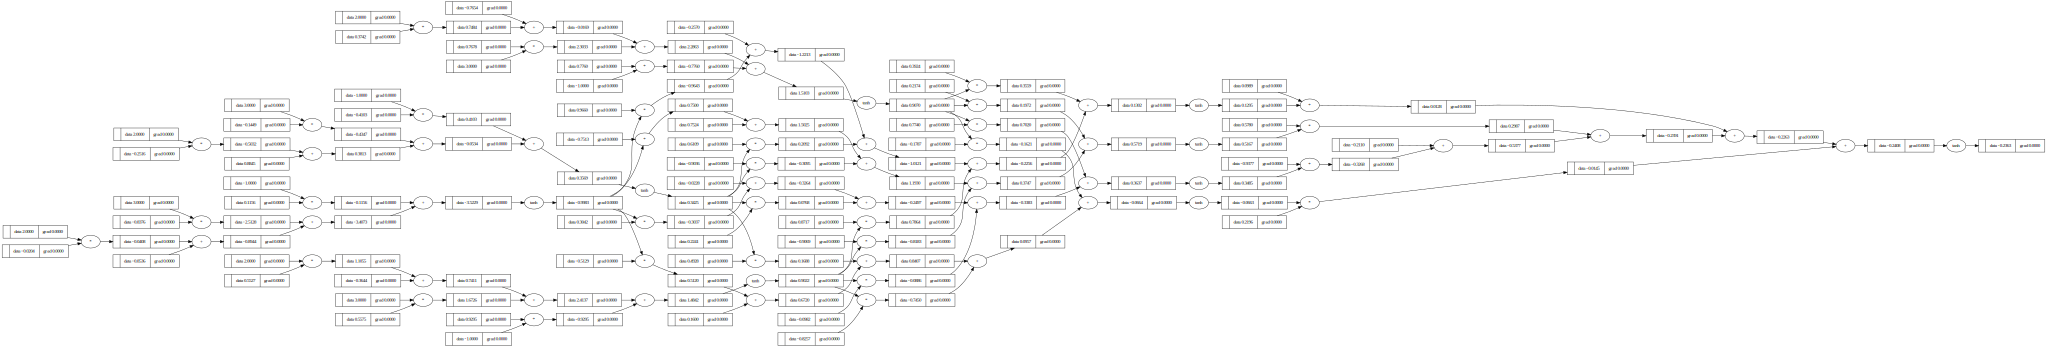

In [6]:
draw_dot(n(x))

In [19]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired target

ypred = [n(x) for x in xs] 

ypred

[Value(data=0.6833993137246862, label=),
 Value(data=0.572656810002525, label=),
 Value(data=-0.7239034975921034, label=),
 Value(data=0.6984401155170804, label=)]

In [8]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]


[Value(data=1.528344289057202, label=),
 Value(data=0.6561076646530543, label=),
 Value(data=0.7547772017202954, label=),
 Value(data=0.16249153424934445, label=)]

In [20]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))
print (loss)

Value(data=2.740653079168543, label=)


In [21]:
loss.backward()
print (n.layers[0].neurons[0].w[0])
print (n.layers[0].neurons[0].w[0].grad)

Value(data=-0.30763004156252594, label=)
0.7472741135663294


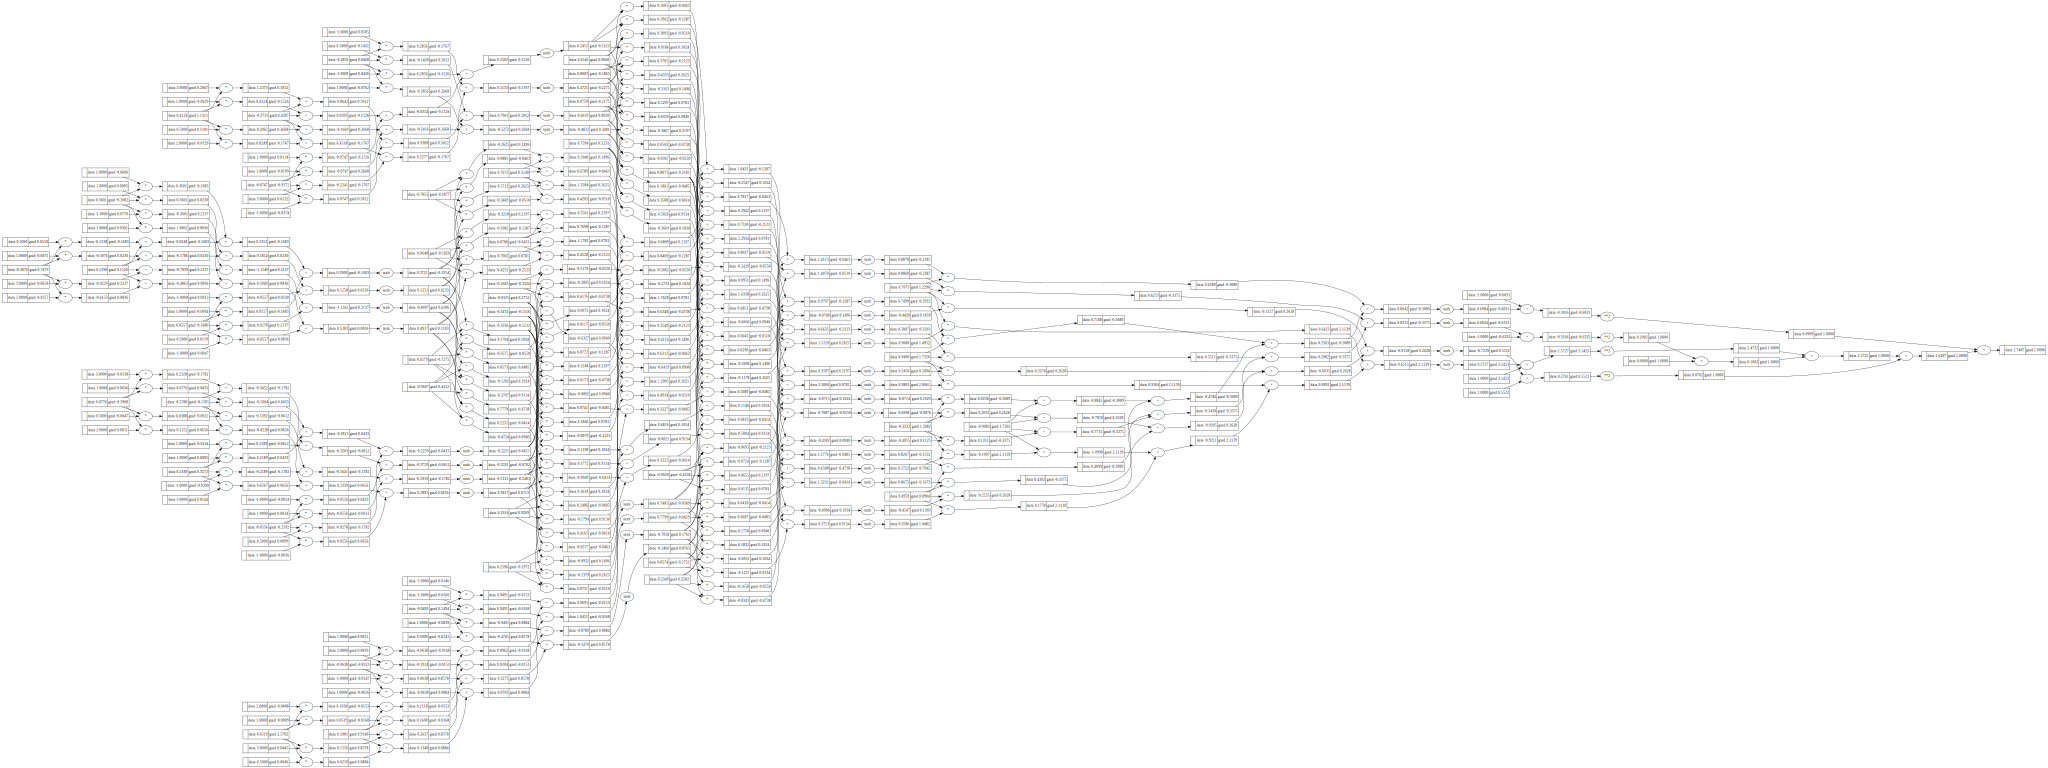

In [22]:
draw_dot(loss)

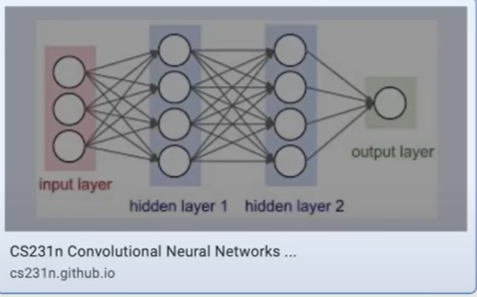

In [23]:
for p in n.parameters():
    p.data += -0.01 * p.grad # because loss is +ve and we want to minimize it, so we subtract it from the parameters


In [24]:
print (n.layers[0].neurons[0].w[0].data)

-0.31510278269818925


In [25]:
# calculate the loss again ie forward pass
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))
print (loss) # previous loss Value(data=2.740653079168543, label=)

Value(data=2.481914639221557, label=)


In [26]:
# backward pass
loss.backward()

In [27]:
for p in n.parameters():
    p.data += -0.01 * p.grad # because loss is +ve and we want to minimize it, so we subtract it from the parameters


In [29]:
# forward pass for new small changes..
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))
print (loss) 
print (ypred)

Value(data=1.8795100880621947, label=)
[Value(data=0.6408703931203428, label=), Value(data=0.24827171816093904, label=), Value(data=-0.7687885659000765, label=), Value(data=0.6273137996844377, label=)]


In [74]:
#backward pass
loss.backward()
# increment the value of the parameters from 0.01 to 0.1
for p in n.parameters():
    p.data += -0.01 * p.grad # because loss is +ve and we want to minimize it, so we subtract it from the parameters


In [73]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))
print (loss) 
print (ypred)

Value(data=0.008174017063281594, label=)
[Value(data=0.9999938688882095, label=), Value(data=-0.9970408323753519, label=), Value(data=-0.9096381700431845, label=), Value(data=0.9999937138362376, label=)]


In [75]:
# got to close enough to the target value
n.parameters()

[Value(data=1.2838549254470313, label=),
 Value(data=3.4957472010220108, label=),
 Value(data=-1.3802377336584601, label=),
 Value(data=1.5331166640608243, label=),
 Value(data=0.5384223054944921, label=),
 Value(data=0.00225929930119524, label=),
 Value(data=0.13996127257192517, label=),
 Value(data=-0.40946952103043444, label=),
 Value(data=-0.3786199362826048, label=),
 Value(data=1.7924012745141078, label=),
 Value(data=-1.7862003585314712, label=),
 Value(data=-0.44077957170020793, label=),
 Value(data=-1.4253200110326967, label=),
 Value(data=2.3466284827501314, label=),
 Value(data=-2.3889790471976093, label=),
 Value(data=-0.027130822271367434, label=),
 Value(data=-1.3523740818912415, label=),
 Value(data=-0.1990877658532839, label=),
 Value(data=-0.5362551910246873, label=),
 Value(data=-0.4964377017216885, label=),
 Value(data=-1.2437828588875683, label=),
 Value(data=1.0667496996682517, label=),
 Value(data=0.12224800869387492, label=),
 Value(data=0.6555506648149513, label

In [79]:
# Re-initialize the input and run the forward pass, backward pass and update the parameters
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired target

In [80]:

for k in range(20):
    # forward pass for new small changes..
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)], Value(0.0))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0 # reset the gradient to 0 before backward pass. This is common mistake
    # Now backward pass
    loss.backward()

    # Gradient descent
    #  increment the value of the parameters from 0.05 
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print (k, loss.data, ypred)


0 3.9763520003796626e-29 [Value(data=1.0, label=), Value(data=-0.9999999999999972, label=), Value(data=-0.9999999999999943, label=), Value(data=1.0, label=)]
1 3.9763520003796626e-29 [Value(data=1.0, label=), Value(data=-0.9999999999999972, label=), Value(data=-0.9999999999999943, label=), Value(data=1.0, label=)]
2 3.9763520003796626e-29 [Value(data=1.0, label=), Value(data=-0.9999999999999972, label=), Value(data=-0.9999999999999943, label=), Value(data=1.0, label=)]
3 3.9763520003796626e-29 [Value(data=1.0, label=), Value(data=-0.9999999999999972, label=), Value(data=-0.9999999999999943, label=), Value(data=1.0, label=)]
4 3.9763520003796626e-29 [Value(data=1.0, label=), Value(data=-0.9999999999999972, label=), Value(data=-0.9999999999999943, label=), Value(data=1.0, label=)]
5 3.9763520003796626e-29 [Value(data=1.0, label=), Value(data=-0.9999999999999972, label=), Value(data=-0.9999999999999943, label=), Value(data=1.0, label=)]
6 3.9763520003796626e-29 [Value(data=1.0, label=), V